### Setup

In [1]:
import networkx as nx
import numpy as np
import tweepy, gensim, nltk, yaml, os, sys
# from nltk.corpus import stopwords
# from nltk.classify import SklearnClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
# %matplotlib inline
nltk.download('vader_lexicon')
# from scipy.spatial import distance

sys.path.append(os.path.abspath("../src/"))
from helper.utils import *
from helper.convmanager import *

# cred = yaml.load(open('../res/credentials.yml'))
# auth = tweepy.OAuthHandler(cred['twitter']['CONSUMER_KEY'], cred['twitter']['CONSUMER_SECRET'])
# auth.set_access_token(cred['twitter']['ACCESS_TOKEN'], cred['twitter']['ACCESS_TOKEN_SECRET'])
# api = tweepy.API(auth)

twaccess = TwitterAccess('../res/credentials.yml')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/piemontec/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Get Tweets and Conversations

In [2]:
%%time
# stackoverflow
search_options = {
    'q':          'christmas',  # query
    'lang':       'en',         # language
    'tweet_mode': 'extended'    # get full tweet text
}
statuses = tweepy.Cursor(twaccess.api.search, **search_options).items(1000)      #
tweets   = [[convert(status)] for status in statuses if is_response(status)]     #
convs    = [extend(twaccess.api, tweet) for tweet in tweets]                     #
merged_convs = merge_conversations(convs, has_common=has_common_tweet)           #

print('Response tweets:', len(tweets))
print('Max conversation length:', max([len(i) for i in convs]), '\n')

Response tweets: 110
Max conversation length: 19 

CPU times: user 5.22 s, sys: 477 ms, total: 5.7 s
Wall time: 2min 10s


### Build the Graph

In [3]:
%%time

plt.rcParams["figure.figsize"] = [15, 7]
plt.style.use('ggplot')

ConvGraph = nx.DiGraph()

# model = gensim.models.KeyedVectors.load_word2vec_format('../models/pretrained/GoogleNews-vectors-negative300.bin.gz', binary=True)
best_conv = [max(merged_convs, key=len)]

for conv in best_conv:
    for i, tweet in enumerate(conv):
        if tweet.reply_to is not None:
            answered_tweet = conv[i+1]
            similarity = tweet.get_similarity(answered_tweet)
            ConvGraph.add_edge(tweet.my_id, tweet.reply_to, weight=similarity)

CPU times: user 307 µs, sys: 1 µs, total: 308 µs
Wall time: 312 µs


#### Draw the Graph

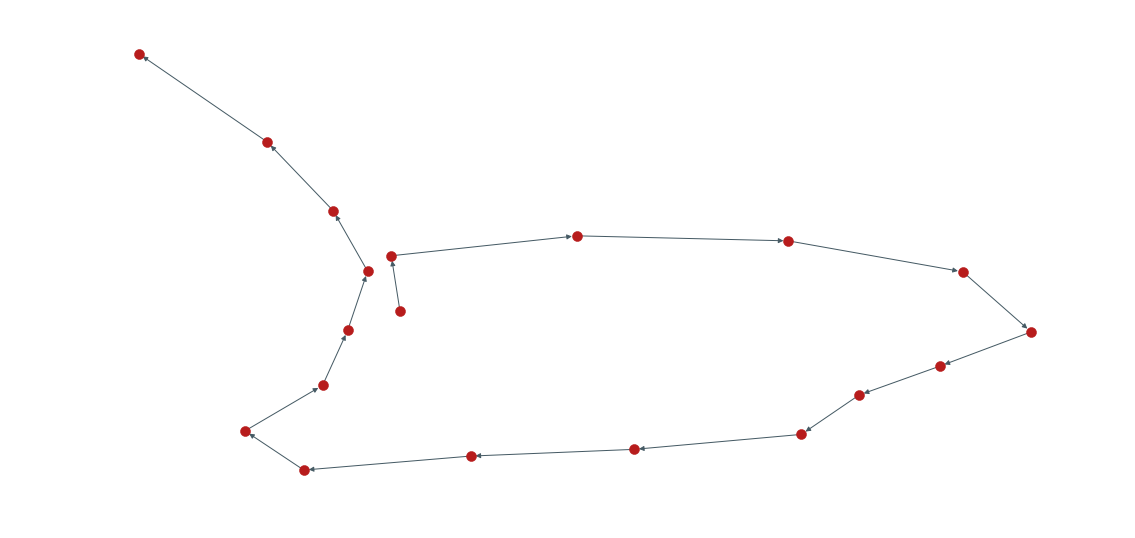

In [4]:
pos = nx.spring_layout(ConvGraph)
edge_labels = nx.get_edge_attributes(ConvGraph, 'weight')

draw_options = {
    'with_labels': False,
    'node_shape' : 'o',
    'node_color' : '#B71C1C',
    'edge_color' : '#455A64',
    'node_size'  : 100,
    'width': 1
}

nx.draw(ConvGraph, pos, **draw_options)
# nx.draw_networkx_edge_labels(ConvGraph, pos, edge_labels=edge_labels, font_color='#006064');

In [5]:
# nx.draw(ConvGraph, pos, **draw_options)